# GA Analytics
## Feature Engineering, Pre-processing, and Modelling
### Blaine Murphy -- September 2021


For the feature engineering phase I will do the following.
- Read in the data exported from the EDA notebook
- Encode categorical features identified in EDA
- Condense data to user level
    - to help answer the business question for identifying big spenders and how to market to them
    - compute the target -- ln(total_user_revenue+1)
    - Calculate user level features with summary statistics for numeric features
- Split data into train, validation, and test for modelling
- Scale the data based on the training data
- Export data sets prepped for modelling

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir(r'D:\Springboard\Capstone 3 maybe\Google Analytics')
os.listdir()

['All features.txt',
 'e390021b-3cdc-4df0-b92e-22082e3ad15b_Data.csv',
 'final_features_updated.csv',
 'GA_features.csv',
 'GA_Test.npz',
 'GA_Train.npz',
 'GA_Validation.npz',
 'GDP by Country world bank.csv',
 'hitsplot.png',
 'life expectency by country_world bank.csv',
 'Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2763936.csv',
 'Metadata_Country_API_SP.DYN.LE00.IN_DS2_en_csv_v2_2764094.csv',
 'Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_2763937.csv',
 'Metadata_Indicator_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2763936.csv',
 'Metadata_Indicator_API_SP.DYN.LE00.IN_DS2_en_csv_v2_2764094.csv',
 'Metadata_Indicator_API_SP.POP.TOTL_DS2_en_csv_v2_2763937.csv',
 'model.png',
 'Multicollinearity drop list.txt',
 'PercentInternetUsers World Bank.csv',
 'Population by country world bank.csv',
 'sample_submission.csv',
 'sample_submission_v2.csv',
 'test.csv',
 'test_v2.csv',
 'train.csv',
 'train_eda.csv',
 'train_v2.csv',
 'train_wrangled.csv',
 'user_train_X.csv',
 'user_train_y.csv',
 

In [3]:
train = pd.read_csv('train_eda.csv',index_col=0,parse_dates=['date','dateTime'])
train.info()

C:\Users\blain\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 901907 entries, 0 to 903652
Data columns (total 51 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   channelGrouping                          901907 non-null  object        
 1   date                                     901907 non-null  datetime64[ns]
 2   fullVisitorId                            901907 non-null  object        
 3   sessionId                                901907 non-null  object        
 4   visitId                                  901907 non-null  int64         
 5   visitNumber                              901907 non-null  int64         
 6   visitStartTime                           901907 non-null  int64         
 7   browser                                  901907 non-null  object        
 8   operatingSystem                          901907 non-null  object        
 9   isMobile                  

A couple of columns to fix. `keyword` is mostly null and I already created new columns from it based on the most frequent search words that resulted in a purchase.  I can drop it now.  

And `timeDiffLastVisit` is mostly null because most of the records are new visits, not repeat visits.  I will fill all of those nulls with the maximum of the `timeDiffLastVisit` column.


In [4]:
train.drop('keyword',axis=1,inplace=True)
train['timeDiffLastVisit'] = train.timeDiffLastVisit.fillna(train.timeDiffLastVisit.max())


In [5]:
### Convert to float for summary statistics below
train['hits'] = train['hits'].astype('float')
train['pageviews'] = train['pageviews'].astype('float')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901907 entries, 0 to 903652
Data columns (total 50 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   channelGrouping                          901907 non-null  object        
 1   date                                     901907 non-null  datetime64[ns]
 2   fullVisitorId                            901907 non-null  object        
 3   sessionId                                901907 non-null  object        
 4   visitId                                  901907 non-null  int64         
 5   visitNumber                              901907 non-null  int64         
 6   visitStartTime                           901907 non-null  int64         
 7   browser                                  901907 non-null  object        
 8   operatingSystem                          901907 non-null  object        
 9   isMobile                  

In [7]:
window_start = train['visitStartTime'].min()
window_end = train['visitStartTime'].max()

### One hot encoding of categorical columns

In [8]:
"','".join(list(train.columns))

"channelGrouping','date','fullVisitorId','sessionId','visitId','visitNumber','visitStartTime','browser','operatingSystem','isMobile','deviceCategory','continent','subContinent','country','region','metro','city','campaign','source','hits','pageviews','bounces','newVisits','transactionRevenue','dollars','purchase','dateTime','hour','weekend','month','time','timeDiffLastVisit','countryPopulation','countryGDP','countryLE','countryPIU','state','keywordStore','keywordMerch','keywordShirt','keywordGoogle','keywordYoutube','keywordShop','keywordApparel','keyword_(Remarketing/Content targeting)','keyword_(User vertical targeting)','keyword_(automatic matching)','keyword_(content targeting)','keyword_(not provided)','keyword_search"

In [9]:
num_cols = ['fullVisitorId','visitNumber','isMobile','hits','pageviews','bounces','newVisits',\
        'visitStartTime','weekend','time','timeDiffLastVisit',\
        'countryPopulation','countryGDP','countryLE','countryPIU','keywordStore',\
        'keywordMerch','keywordShirt','keywordGoogle',\
        'keywordYoutube','keywordShop','keywordApparel',\
        'keyword_(Remarketing/Content targeting)',\
        'keyword_(User vertical targeting)','keyword_(automatic matching)',\
        'keyword_(content targeting)','keyword_(not provided)','keyword_search',\
        'dollars','transactionRevenue']

In [10]:
dummy_cols = ['channelGrouping','browser','operatingSystem',\
              'deviceCategory','subContinent','city','state',\
              'campaign','source','month','hour']

In [11]:
### convert month to object for label encoding, ditto for hour
train['month'] = train['month'].astype('object')
train['month'].dtype

train['hour'] = train['hour'].astype('object')


In [12]:
train = pd.concat([train[num_cols],pd.get_dummies(train[dummy_cols])], axis=1)

In [13]:
train.shape

(901907, 344)

In [14]:
train_cols = list(train.columns)

### Grouping by user

In [15]:
bool_cols = ['isMobile','weekend','bounces','keywordStore','keywordMerch','keywordShirt',\
             'keywordGoogle','keywordYoutube','keywordShop','keywordApparel',\
             'keyword_(Remarketing/Content targeting)','keyword_(User vertical targeting)',\
             'keyword_(automatic matching)','keyword_(content targeting)','keyword_(not provided)','keyword_search' ]

In [16]:
user_groupby = train.groupby('fullVisitorId', as_index=True)

Creation of target in a new user level dataframe

In [17]:
### Function for creation of target column ln(total_revenue_per_user + 1)
TargetFunc = lambda x: np.log(sum(x) + 1.0)

### Calculate target
X = user_groupby[['transactionRevenue']].agg(TargetFunc)


In [18]:
### Create features based on visits
X['visits'] = user_groupby[['transactionRevenue']].count()
X['visitMax'] = user_groupby['visitNumber'].max()
X['visitMin'] = user_groupby['visitNumber'].min()

### Create features based on time between visits and start and end of the data window
X['timeTilFirstVisit'] = user_groupby['visitStartTime'].agg(lambda x: min(x) - window_start)
X['timeLastVisitFromEnd'] = user_groupby['visitStartTime'].agg(lambda x: window_end - max(x))



### Create statistical measures of numerical columns
for col in ['hits','pageviews','timeDiffLastVisit']:
    dum = user_groupby[[col]].agg(['min','max','median','mean','std'])
    dum.columns = [col+i.capitalize() for i in ['min','max','median','mean','std']]
    X = pd.concat([X,dum], axis=1)
    del dum

    
for col in ['countryPopulation','countryGDP','countryLE','countryPIU']:
    dum = user_groupby[[col]].agg(['mean','std'])
    dum.columns = [col+i.capitalize() for i in ['mean','std']]
    X = pd.concat([X,dum], axis=1)
    del dum
    
### calculate mean of boolean columns
for col in bool_cols:
    #X[col] = user_groupby[col].mean()
    
    dum = user_groupby[[col]].mean()
    dum.columns = [col+'Mean']
    X = pd.concat([X,dum], axis=1)
    del dum

### Mean of dummy columns with correct column naming
for col in dummy_cols:
    for dumi_col in [i for i in train_cols if i.startswith(col)]:
        dum = user_groupby[[dumi_col]].mean()
        dum.columns = [dumi_col+'Mean']
        X = pd.concat([X,dum], axis=1)
        del dum



    
X.head()

,transactionRevenue,visits,visitMax,visitMin,timeTilFirstVisit,timeLastVisitFromEnd,hitsMin,hitsMax,hitsMedian,hitsMean,...,hour_14Mean,hour_15Mean,hour_16Mean,hour_17Mean,hour_18Mean,hour_19Mean,hour_20Mean,hour_21Mean,hour_22Mean,hour_23Mean
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
4823595352351,0.0,1,1,1,7976698,23645683,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5103959234087,0.0,1,1,1,1782396,29839985,10.0,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10278554503158,0.0,1,1,1,6994654,24627727,11.0,11.0,11.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20424342248747,0.0,1,1,1,10544089,21078292,17.0,17.0,17.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26722803385797,0.0,1,1,1,26623582,4998799,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
X_cols = X.columns

In [20]:
nulls = X.isna().sum().T
nulls[nulls>0]

hitsStd                 631804
pageviewsStd            631804
timeDiffLastVisitStd    631804
countryPopulationStd    631804
countryGDPStd           631804
countryLEStd            631804
countryPIUStd           631804
dtype: int64

In [21]:
X = X.fillna(0)

In [22]:
#del train

In [23]:
y = X.pop('transactionRevenue')

In [24]:
X.shape

(722668, 358)

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    dropped=[]
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        
        ### Create data frame with features column and 
        ### variance inflation factor column
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        
        
        if vif['VIFactor'].max() > vif_threshold:
            dropped.append(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0])
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
            #if count==45:
                #print('early stop for plotting intermediate step')
                #return df, vif.sort_values('VIFactor')  
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')

In [28]:
### Use only a fraction of the total set for calculating vif
#frac_for_vif=0.5
#final_X, final_vif = iterate_vif(X.sample(frac=frac_for_vif), vif_threshold = 2)
#del frac_for_vif

Iteration # 1


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing pageviewsMean with VIF of 12866.558853
Iteration # 2


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing timeDiffLastVisitMin with VIF of 5140.597565
Iteration # 3


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing channelGrouping_DirectMean with VIF of 3095.226798
Iteration # 4


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing hitsMin with VIF of 1413.460876
Iteration # 5


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing deviceCategory_desktopMean with VIF of 2240.571371
Iteration # 6


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing isMobileMean with VIF of 1558.188844
Iteration # 7


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing operatingSystem_WindowsMean with VIF of 1254.257758
Iteration # 8


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing keyword_searchMean with VIF of 966.199870
Iteration # 9


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing campaign_Data Share PromoMean with VIF of 1127.683490
Iteration # 10


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing browser_ChromeMean with VIF of 1030.678377
Iteration # 11


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing channelGrouping_Organic SearchMean with VIF of 1126.695030
Iteration # 12


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing month_2Mean with VIF of 568.216257
Iteration # 13


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing source_PartnersMean with VIF of 739.503303
Iteration # 14


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing hitsMean with VIF of 475.792441
Iteration # 15


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing pageviewsMax with VIF of 361.411058
Iteration # 16


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing channelGrouping_SocialMean with VIF of 335.590121
Iteration # 17


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing hour_23Mean with VIF of 225.407011
Iteration # 18


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing timeDiffLastVisitMean with VIF of 172.818357
Iteration # 19


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing subContinent_Northern AmericaMean with VIF of 185.849077
Iteration # 20


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_New YorkMean with VIF of 148.737577
Iteration # 21


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_CaliforniaMean with VIF of 122.508338
Iteration # 22


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing source_googleMean with VIF of 106.420462
Iteration # 23


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing pageviewsMedian with VIF of 95.096359
Iteration # 24


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing city_not availableMean with VIF of 79.340176
Iteration # 25


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing timeLastVisitFromEnd with VIF of 60.439528
Iteration # 26


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing deviceCategory_mobileMean with VIF of 59.076608
Iteration # 27


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing hitsStd with VIF of 46.110162
Iteration # 28


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing campaign_(not set)Mean with VIF of 56.996874
Iteration # 29


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_PennsylvaniaMean with VIF of 85.900100
Iteration # 30


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_WashingtonMean with VIF of 48.048850
Iteration # 31


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_NotUSMean with VIF of 53.949551
Iteration # 32


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing channelGrouping_Paid SearchMean with VIF of 39.551551
Iteration # 33


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_IllinoisMean with VIF of 39.550525
Iteration # 34


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing keyword_(not provided)Mean with VIF of 30.966933
Iteration # 35


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_TexasMean with VIF of 27.744797
Iteration # 36


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_ColoradoMean with VIF of 22.654781
Iteration # 37


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_MassachusettsMean with VIF of 20.316989
Iteration # 38


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_GeorgiaMean with VIF of 26.676573
Iteration # 39


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing timeTilFirstVisit with VIF of 20.116646
Iteration # 40


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing visitMax with VIF of 18.657920
Iteration # 41


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing channelGrouping_ReferralMean with VIF of 17.918270
Iteration # 42


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing pageviewsMin with VIF of 17.262476
Iteration # 43


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing countryGDPMean with VIF of 15.127709
Iteration # 44


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_IowaMean with VIF of 427.925690
Iteration # 45


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_IndianaMean with VIF of 317.242007
Iteration # 46


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_NebraskaMean with VIF of 270.990317
Iteration # 47


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_ArizonaMean with VIF of 84.150813
Iteration # 48


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_OhioMean with VIF of 14.144609
Iteration # 49


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing hitsMax with VIF of 12.992709
Iteration # 50


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_North CarolinaMean with VIF of 12.900601
Iteration # 51


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_MichiganMean with VIF of 9.593952
Iteration # 52


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_TennesseeMean with VIF of 8.328811
Iteration # 53


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing city_MinneapolisMean with VIF of 7.263147
Iteration # 54


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing channelGrouping_DisplayMean with VIF of 7.174712
Iteration # 55


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing timeDiffLastVisitMedian with VIF of 7.033057
Iteration # 56


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing countryPopulationMean with VIF of 5.098741
Iteration # 57


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_South CarolinaMean with VIF of 4.847291
Iteration # 58


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing operatingSystem_iOSMean with VIF of 3.385674
Iteration # 59


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing keywordGoogleMean with VIF of 3.338812
Iteration # 60


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing city_Kansas CityMean with VIF of 3.331553
Iteration # 61


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing month_11Mean with VIF of 2.769966
Iteration # 62


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing state_FloridaMean with VIF of 2.624802
Iteration # 63


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing campaign_AW - AccessoriesMean with VIF of 2.346881
Iteration # 64


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing city_HamdenMean with VIF of 2.330851
Iteration # 65


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing hour_17Mean with VIF of 2.314031
Iteration # 66


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing countryLEStd with VIF of 2.240670
Iteration # 67


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing subContinent_AustralasiaMean with VIF of 2.134498
Iteration # 68


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing subContinent_Southeast AsiaMean with VIF of 2.090557
Iteration # 69


C:\Users\blain\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Complete


In [34]:
#final_features = list(final_X.columns)
#with open('final_features.csv','w') as f:
#    [f.write(ff+'\n') for ff in final_features]
#X = X[final_features]

In [26]:
### Read in columns to drop from VIF calculation.  Don't want to have to do that more than once, takes too long
with open('vif output.txt','r') as f:
    vif_out = f.read().split('\n')
vif_out = [i for i in vif_out if i.startswith('Removing')]
import re
vif_dropped = []
for i in vif_out:
    vif_dropped.append(re.search('ing (.*?) with',i).group(1))

In [27]:
#vif_dropped.remove('state_NotUSMean')
#vif_dropped.remove('isMobileMean')

In [28]:
X = X.drop(columns=vif_dropped)
print(X.shape)

(722668, 290)


In [29]:
final_features = X.columns
with open('final_features_updated.csv','w') as f:
    [f.write(ff+'\n') for ff in final_features]
        

In [30]:
X.shape

(722668, 290)

Now splitting into train and test sets

In [31]:
random_seed = 33

In [32]:
### Split into 70-20-10 train-validation-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.333, random_state=random_seed)


In [33]:
print('Train features:', X_train.shape)
print('Train target:', y_train.shape)
print('Validation features:',X_val.shape)
print('Validation target:',y_val.shape)
print('Test features:',X_test.shape)
print('Test target:',y_test.shape)


Train features: (505867, 290)
Train target: (505867,)
Validation features: (144606, 290)
Validation target: (144606,)
Test features: (72195, 290)
Test target: (72195,)


In [34]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train, X_test, X_val = ss.transform(X_train), ss.transform(X_test), ss.transform(X_val)




In [35]:
np.savez('GA_Train', inputs=X_train, targets = y_train)
np.savez('GA_Validation', inputs=X_val, targets = y_val)
np.savez('GA_Test', inputs=X_test, targets = y_test)

Data saved.

In [39]:
import pickle
pickle.dump(ss, open(r'C:\Users\blain\GitHub\Capstone_GA-Revenue-Prediction\StandardScaler.pkl','wb'))

Standard scaler saved

In [37]:
print('Train Frac of purchasers:', np.sum(y_train > 1) / y_train.shape[0])
print('Validation Frac purchasers:', np.sum(y_val > 1) / y_val.shape[0])
print('Test Frac purchasers:', np.sum(y_test > 1) / y_test.shape[0])

Train Frac of purchasers: 0.014132173081066762
Validation Frac purchasers: 0.013747700648659116
Test Frac purchasers: 0.013865226123692776


In [38]:
print('Train mean revenue:', np.mean(y_train))
print('Validation mean revenue:', np.mean(y_val))
print('Test mean revenue:', np.mean(y_test))

Train mean revenue: 0.25210859307122324
Validation mean revenue: 0.24477637333751118
Test mean revenue: 0.24635544682826294


## Modelling phase

### Linear Regression with Lasso to get a baseline model performance and quick look at feature importance

In [1]:
import pandas as pd
import numpy as np
import os 

os.chdir(r'D:\Springboard\Capstone 3 maybe\Google Analytics')

In [2]:
### Loading data
train = np.load('GA_Train.npz')
valid = np.load('GA_Validation.npz')
test = np.load('GA_Test.npz')
print(train['inputs'].shape)
print(train['targets'].shape)

(505867, 290)
(505867,)


In [3]:
with open('final_features_updated.csv','r') as f:
    final_features = f.read().split('\n')[:-1]


## Base case
Use the mean of the training set as a prediction for the testing set and check RMSE

In [4]:
from sklearn.metrics import mean_squared_error
mean_train = np.mean(train['targets'])

test_target_mean = np.zeros(test['targets'].shape)
test_target_mean = test_target_mean + mean_train

In [5]:
rmse = np.sqrt(mean_squared_error(test['targets'],test_target_mean))
print(f'RMSE for mean: {rmse:.3f}')

RMSE for mean: 2.083


Now I will look to improve upon that with deep learning.

### Moving on to deep learning with Keras/TensorFlow

In [6]:
import tensorflow as tf


In [7]:
train_num_purchasers = np.sum(train['targets'] > 1) 

#train['targets'].shape[0] / train_num_purchasers

print('There should be a purchase every {:.0f} records'.format(train['targets'].shape[0] / train_num_purchasers))


There should be a purchase every 71 records


In the training set I would expect to see one purchase every 71 records. I will try a batch size of 500 to try to get multiple purchases in each batch

In [8]:
### Declare some variables for modelling 

input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50


Model building

In [9]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = model.fit(x=train['inputs'],
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(valid['inputs'],valid['targets']),
          verbose = 2)

Epoch 1/50
1012/1012 - 3s - loss: 3.2574 - root_mean_squared_error: 1.8048 - mean_absolute_error: 0.4378 - val_loss: 2.8261 - val_root_mean_squared_error: 1.6811 - val_mean_absolute_error: 0.3334
Epoch 2/50
1012/1012 - 3s - loss: 2.9253 - root_mean_squared_error: 1.7104 - mean_absolute_error: 0.3690 - val_loss: 2.7434 - val_root_mean_squared_error: 1.6563 - val_mean_absolute_error: 0.3328
Epoch 3/50
1012/1012 - 3s - loss: 2.8598 - root_mean_squared_error: 1.6911 - mean_absolute_error: 0.3588 - val_loss: 2.8049 - val_root_mean_squared_error: 1.6748 - val_mean_absolute_error: 0.3783
Epoch 4/50
1012/1012 - 3s - loss: 2.8088 - root_mean_squared_error: 1.6760 - mean_absolute_error: 0.3447 - val_loss: 2.7210 - val_root_mean_squared_error: 1.6496 - val_mean_absolute_error: 0.3234
Epoch 5/50
1012/1012 - 2s - loss: 2.7585 - root_mean_squared_error: 1.6609 - mean_absolute_error: 0.3414 - val_loss: 2.6914 - val_root_mean_squared_error: 1.6406 - val_mean_absolute_error: 0.3045
Epoch 6/50
1012/1012

In [11]:
import matplotlib.pyplot as plt
def PlotLoss(hist):
    plt.plot(np.sqrt(hist.history['loss']), label='Loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    

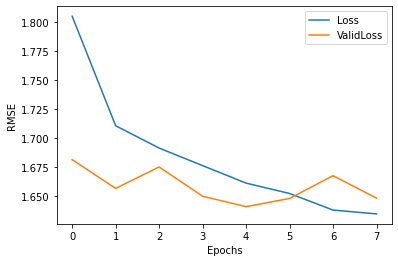

In [12]:
PlotLoss(history)

In [13]:
model.metrics_names

['loss', 'root_mean_squared_error', 'mean_absolute_error']

In [14]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([train['inputs'],valid['inputs'], test['inputs']],
                                             [train['targets'],valid['targets'], test['targets']]):
    
    dum = model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
base_seq_nn = pd.DataFrame(perf,index = ['train','validation','test'])
base_seq_nn

2257/2257 [==============================] - 2s 716us/step - loss: 2.7672 - root_mean_squared_error: 1.6635 - mean_absolute_error: 0.3068


,RMSE
train,1.622523
validation,1.640564
test,1.663484


The test RMSE is higher than the validation RMSE suggesting that this model is overfitting to the train and validation sets.  Now visualizing the model predictions.

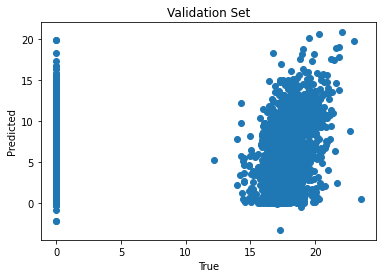

In [15]:
plt.scatter(valid['targets'],model.predict(valid['inputs']))
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Validation Set')
plt.show()

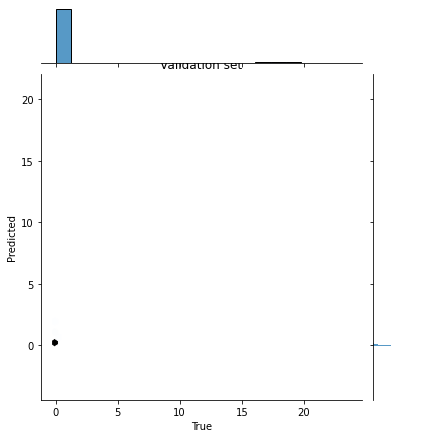

In [16]:
import seaborn as sns
sns.jointplot(x=valid['targets'],y=model.predict(valid['inputs']).reshape(-1), kind='hex')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Validation set')
plt.show()

It is hard to see the model predictions due to the very large numbers of ~0-0 true-predictions.  I will null these out and see if what the predictions look like.

In [17]:
mask = (valid['targets']<1.0) & (model.predict(valid['inputs']).reshape(-1)<1.0)
print(sum(mask))

138410


In [18]:
valid_target_masked = np.copy(valid['targets'])
valid_target_masked[mask==True] = np.NAN

valid_predicted_masked = np.copy(model.predict(valid['inputs']).reshape(-1))
valid_predicted_masked[mask==True] = np.NAN

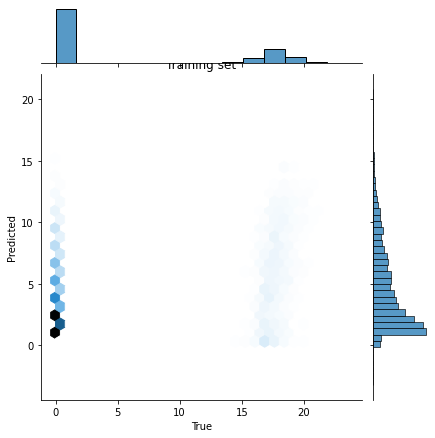

In [19]:
import seaborn as sns
sns.jointplot(x=valid_target_masked , y=valid_predicted_masked, dropna=True, kind='hex')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training set')
plt.show()

Not great. The 3 layer NN does not do a great job of predicting user revenue.  As shown before, only about 1% of the users made a purchase, and I believe this imbalance could be what's causing the poor results.  
___
## NN Classifier for purchase
Now I will try to create a NN model that predicts only whether a purchase was made. If that is succesful it could be an input into the regression model.  



In [20]:
train_purchase = 1.0 * np.array( [train['targets'] == 0, train['targets']>0] ).T
valid_purchase = 1.0 * np.array( [valid['targets'] ==0 , valid['targets'] > 0] ).T
test_purchase = 1.0 * np.array( [test['targets'] ==0 , test['targets'] > 0] ).T

In [21]:
### 
input_size = train['inputs'].shape[1]
output_size = 2
hidden_layer_size = 64
batch_size = 500
epochs = 50

In [22]:
clf_model = tf.keras.Sequential()
clf_model.add(tf.keras.layers.Dense(hidden_layer_size,activation='relu'))
clf_model.add(tf.keras.layers.Dropout(.2))
clf_model.add(tf.keras.layers.Dense(hidden_layer_size,activation='relu'))
clf_model.add(tf.keras.layers.Dense(hidden_layer_size,activation='relu'))
clf_model.add(tf.keras.layers.Dense(output_size,activation='softmax'))

clf_model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])




In [23]:
stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = clf_model.fit(train['inputs'],train_purchase,
                        batch_size=batch_size,
                        epochs=epochs,
                        shuffle=True,
                        callbacks=stop,                    
                        validation_data=(valid['inputs'],valid_purchase),
                        verbose=2
                       )                    

Epoch 1/50
1012/1012 - 6s - loss: 0.0453 - auc: 0.9966 - precision: 0.9857 - recall: 0.9857 - val_loss: 0.0310 - val_auc: 0.9983 - val_precision: 0.9877 - val_recall: 0.9877
Epoch 2/50
1012/1012 - 4s - loss: 0.0323 - auc: 0.9979 - precision: 0.9871 - recall: 0.9871 - val_loss: 0.0300 - val_auc: 0.9979 - val_precision: 0.9880 - val_recall: 0.9880
Epoch 3/50
1012/1012 - 4s - loss: 0.0306 - auc: 0.9981 - precision: 0.9875 - recall: 0.9875 - val_loss: 0.0293 - val_auc: 0.9985 - val_precision: 0.9882 - val_recall: 0.9882
Epoch 4/50
1012/1012 - 4s - loss: 0.0297 - auc: 0.9983 - precision: 0.9878 - recall: 0.9878 - val_loss: 0.0294 - val_auc: 0.9985 - val_precision: 0.9880 - val_recall: 0.9880
Epoch 5/50
1012/1012 - 4s - loss: 0.0291 - auc: 0.9984 - precision: 0.9879 - recall: 0.9879 - val_loss: 0.0296 - val_auc: 0.9982 - val_precision: 0.9882 - val_recall: 0.9882
Epoch 6/50
1012/1012 - 4s - loss: 0.0286 - auc: 0.9984 - precision: 0.9879 - recall: 0.9879 - val_loss: 0.0295 - val_auc: 0.9984 -

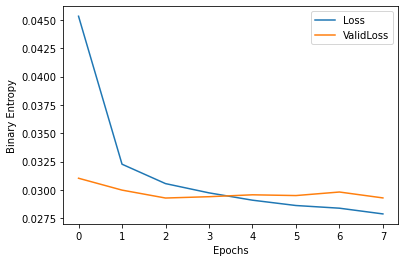

In [24]:
def PlotClfLoss(hist):
    plt.plot(hist.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Entropy')
    plt.legend()
    plt.show()
    
PlotClfLoss(history)

In [25]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix
train_predict_proba = clf_model.predict(train['inputs'])[:,1]
valid_predict_proba = clf_model.predict(valid['inputs'])[:,1]
test_predict_proba = clf_model.predict(test['inputs'])[:,1]

train_predicts = 1 * (train_predict_proba > 0.1)
valid_predicts = 1 * (valid_predict_proba > 0.1)

print('Train ROC AUC:', roc_auc_score(train_predicts ,train_predict_proba ))
print('Train Recall:',recall_score(train_purchase[:,1], train_predicts))
print('Train Precision:',precision_score(train_purchase[:,1], train_predicts))
print()
print('Validation ROC AUC:', roc_auc_score(valid_purchase[:,1], valid_predict_proba ))
print('Validation Recall:',recall_score(valid_purchase[:,1], valid_predicts))
print('Validation Precision:',precision_score(valid_purchase[:,1], valid_predicts))

Train ROC AUC: 1.0
Train Recall: 0.7262554203385089
Train Precision: 0.4329914102243349

Validation ROC AUC: 0.9859581241815701
Validation Recall: 0.7344064386317908
Validation Precision: 0.4233111046680197


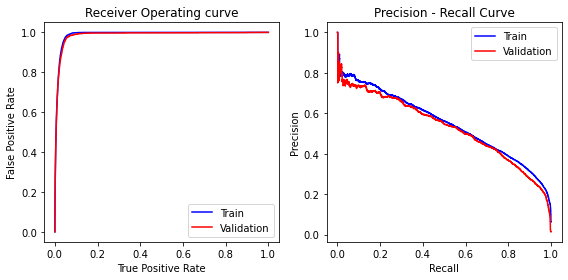

In [26]:
from sklearn.metrics import roc_curve, precision_recall_curve
fig,ax = plt.subplots(1,2, figsize = (8,4), tight_layout=True)

tpr, fpr, thresh = roc_curve(train_purchase[:,1], train_predict_proba)
ax[0].plot(tpr,fpr,c='blue')

tpr, fpr, thresh = roc_curve(valid_purchase[:,1], valid_predict_proba)
ax[0].plot(tpr,fpr,c='red')

ax[0].set_title('Receiver Operating curve')
ax[0].set_xlabel('True Positive Rate')
ax[0].set_ylabel('False Positive Rate')
ax[0].legend(labels=['Train','Validation'],loc='lower right')

p,r,t = precision_recall_curve(train_purchase[:,1], train_predict_proba)
ax[1].plot(r,p,c='blue')
p,r,t = precision_recall_curve(valid_purchase[:,1], valid_predict_proba)
ax[1].plot(r,p,c='red')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision - Recall Curve')
ax[1].legend(labels=['Train','Validation'])
plt.show()



These features are pretty good at predicting if there was a purchase, but I didn't take the final pre-processing steps that I normally would for a classification problem (multicollinearity).  Quick check on the test set.

In [27]:
print('Test ROC AUC:', roc_auc_score(test_purchase[:,1], test_predict_proba ))

Test ROC AUC: 0.9831362277635839


The classifier looks useful.  Now I will append the classification probability to the model and re-do the regression.

## Using classifier prediction in regression model
Now how to use the predicted purchase in a regression model.  Is there a way to combine the classification and regression models into one? A model inside a model? For now I will concatenate the classification predicted probabilities to the inputs of the data sets, an create a new regression NN.

In [28]:
train['inputs'].shape

(505867, 290)

In [29]:
X_train = np.hstack([train['inputs'],train_predict_proba.reshape(-1,1)])

X_valid = np.hstack([valid['inputs'],valid_predict_proba.reshape(-1,1)])

X_test = np.hstack([test['inputs'],test_predict_proba.reshape(-1,1)])
print(X_train.shape)

(505867, 291)


Now going back to a tf regression modelling

In [30]:
input_size = X_train.shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50


In [31]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))




model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [32]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(x=X_train,
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid,valid['targets']),
          verbose = 2)

Epoch 1/50
1012/1012 - 3s - loss: 3.2266 - root_mean_squared_error: 1.7963 - mean_absolute_error: 0.4215 - val_loss: 2.7597 - val_root_mean_squared_error: 1.6612 - val_mean_absolute_error: 0.3292
Epoch 2/50
1012/1012 - 3s - loss: 2.8712 - root_mean_squared_error: 1.6945 - mean_absolute_error: 0.3565 - val_loss: 2.7126 - val_root_mean_squared_error: 1.6470 - val_mean_absolute_error: 0.3235
Epoch 3/50
1012/1012 - 3s - loss: 2.7983 - root_mean_squared_error: 1.6728 - mean_absolute_error: 0.3432 - val_loss: 2.7407 - val_root_mean_squared_error: 1.6555 - val_mean_absolute_error: 0.3135
Epoch 4/50
1012/1012 - 3s - loss: 2.7666 - root_mean_squared_error: 1.6633 - mean_absolute_error: 0.3362 - val_loss: 2.6781 - val_root_mean_squared_error: 1.6365 - val_mean_absolute_error: 0.3206
Epoch 5/50
1012/1012 - 3s - loss: 2.7322 - root_mean_squared_error: 1.6529 - mean_absolute_error: 0.3302 - val_loss: 2.7143 - val_root_mean_squared_error: 1.6475 - val_mean_absolute_error: 0.3190
Epoch 6/50
1012/1012

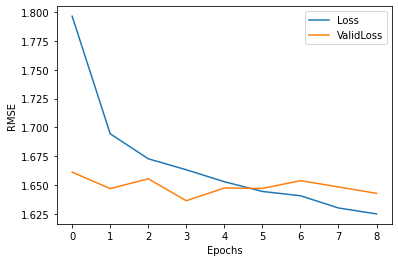

In [33]:
def PlotLoss(hist):
    plt.plot(np.sqrt(hist.history['loss']), label='Loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
PlotLoss(history)

In [34]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([X_train,X_valid, X_test],
                                             [train['targets'],valid['targets'], test['targets']]):
    
    dum = model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
seq_nn_w_clf = pd.DataFrame(perf,index = ['train','validation','test'])
seq_nn_w_clf

2257/2257 [==============================] - 2s 753us/step - loss: 2.7472 - root_mean_squared_error: 1.6575 - mean_absolute_error: 0.3227


,RMSE
train,1.627873
validation,1.636500
test,1.657454


In [35]:
base_seq_nn

,RMSE
train,1.622523
validation,1.640564
test,1.663484


The model accuracy for the validation and test sets are about the same, but there is evidence of a little less overfitting to the training set for this model.

### Now using Keras' Functional API I will attempt a network of layers to create a regressor and classifier in 1 model
I will do this 2 ways:
- the classifier as a probability multiplied by the regression output
- the classifier as an input into the regression

The model will use the same inputs, and have two ouputs, a classifier for a purchase and a regressor for the size of the purchase. The model will optimize for both at the same time.

In [36]:
#import tensorflow as tf
#import pandas as pd
#import matplotlib.pyplot as plt

In [37]:
input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 100

In [38]:
### Creation of classifier targets (already have regrssion targets)
train_purchase = 1.0 * np.array( [train['targets'] == 0, train['targets']>0] ).T
valid_purchase = 1.0 * np.array( [valid['targets'] ==0 , valid['targets'] > 0] ).T
test_purchase = 1.0 * np.array( [test['targets'] ==0 , test['targets'] > 0] ).T

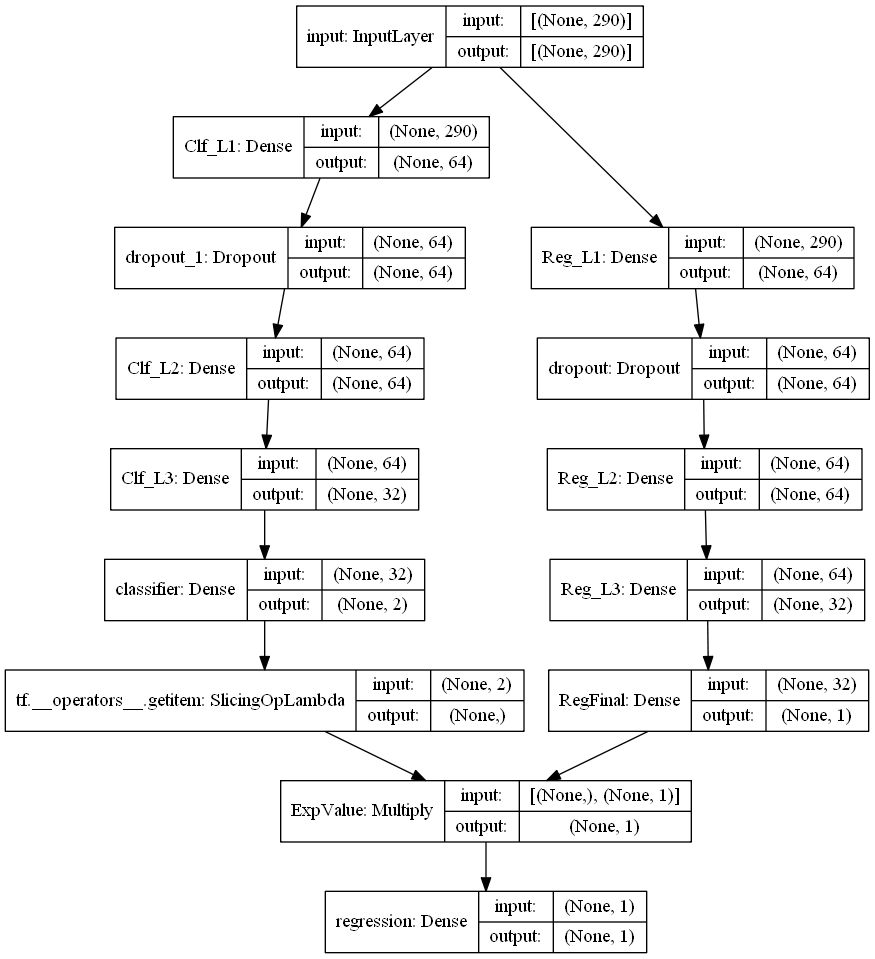

In [39]:
tf.keras.backend.clear_session()
### Create input layer
inputs = tf.keras.Input(shape=(input_size,),name='input') # shape (features,)

### Now build regression portion of model
reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L1')(inputs) # shape (None, 64)
reg = tf.keras.layers.Dropout(.2)(reg)
reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L2')(reg) # shape (None, 64)
reg = tf.keras.layers.Dense(hidden_layer_size//2, activation='relu', name='Reg_L3')(reg) # shape (None, 64)
reg = tf.keras.layers.Dense(1, name='RegFinal')(reg) # shape (None,1)


### Building the classifier
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L1')(inputs) # shape (None, 64)
clf = tf.keras.layers.Dropout(.2)(clf)
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L2')(clf) # shape (None, 64)
clf = tf.keras.layers.Dense(hidden_layer_size//2, activation = 'relu', name='Clf_L3')(clf) # shape (None, 64)
clf_out = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(clf) # shape (None, 2)

### Final step, multiply purchase prediction by regression prediction
reg_out = tf.keras.layers.multiply([clf_out[:,1], reg], name='ExpValue')
reg_out = tf.keras.layers.Dense(output_size, name='regression')(reg_out)

complex_model = tf.keras.Model(inputs=inputs, outputs = [reg_out, clf_out])

tf.keras.utils.plot_model(complex_model, show_shapes=True)

#complex_model.summary()


In [40]:
complex_model.compile(optimizer='adam',
                     loss={'classifier':tf.keras.losses.BinaryCrossentropy(from_logits=False),
                          'regression': tf.keras.losses.MeanSquaredError()},
                     metrics={'classifier':[tf.keras.metrics.AUC(), 
                                            tf.keras.metrics.Precision(),
                                            tf.keras.metrics.Recall()],
                             'regression': [tf.keras.metrics.RootMeanSquaredError(),
                                          tf.keras.metrics.MeanAbsoluteError()]}
                     )

In [41]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = complex_model.fit(train['inputs'],
                           {'regression':train['targets'],'classifier':train_purchase},
                           epochs=epochs,
                           batch_size=batch_size,
                           callbacks=earlystop,
                           validation_data=(valid['inputs'],{'regression':valid['targets'],
                                                              'classifier':valid_purchase}),
                           verbose=2
                           )

Epoch 1/100
1012/1012 - 6s - loss: 3.2966 - regression_loss: 3.2091 - classifier_loss: 0.0875 - regression_root_mean_squared_error: 1.7914 - regression_mean_absolute_error: 0.3567 - classifier_auc: 0.9962 - classifier_precision: 0.9759 - classifier_recall: 0.9759 - val_loss: 2.8251 - val_regression_loss: 2.7726 - val_classifier_loss: 0.0525 - val_regression_root_mean_squared_error: 1.6651 - val_regression_mean_absolute_error: 0.3279 - val_classifier_auc: 0.9976 - val_classifier_precision: 0.9767 - val_classifier_recall: 0.9767
Epoch 2/100
1012/1012 - 5s - loss: 2.9828 - regression_loss: 2.9305 - classifier_loss: 0.0523 - regression_root_mean_squared_error: 1.7119 - regression_mean_absolute_error: 0.3292 - classifier_auc: 0.9975 - classifier_precision: 0.9771 - classifier_recall: 0.9771 - val_loss: 2.9057 - val_regression_loss: 2.8527 - val_classifier_loss: 0.0530 - val_regression_root_mean_squared_error: 1.6890 - val_regression_mean_absolute_error: 0.3327 - val_classifier_auc: 0.9977 -

In [42]:
complex_model.metrics_names

['loss',
 'regression_loss',
 'classifier_loss',
 'regression_root_mean_squared_error',
 'regression_mean_absolute_error',
 'classifier_auc',
 'classifier_precision',
 'classifier_recall']

In [43]:
history.history.keys()

dict_keys(['loss', 'regression_loss', 'classifier_loss', 'regression_root_mean_squared_error', 'regression_mean_absolute_error', 'classifier_auc', 'classifier_precision', 'classifier_recall', 'val_loss', 'val_regression_loss', 'val_classifier_loss', 'val_regression_root_mean_squared_error', 'val_regression_mean_absolute_error', 'val_classifier_auc', 'val_classifier_precision', 'val_classifier_recall'])

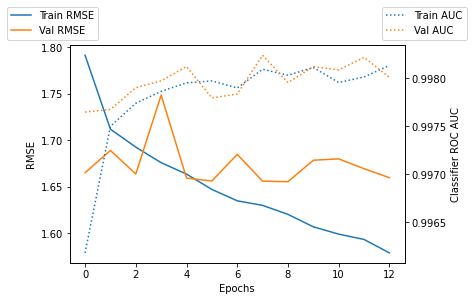

In [44]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(6,4))
ax.plot(history.history['regression_root_mean_squared_error'] ,label='Train RMSE')
ax.plot(history.history['val_regression_root_mean_squared_error'] ,label='Val RMSE')

ax2 = ax.twinx()

ax2.plot(history.history['classifier_auc'],label='Train AUC', linestyle=':')
ax2.plot(history.history['val_classifier_auc'],label = 'Val AUC', linestyle=':')

ax.set_xlabel('Epochs')

ax.set_ylabel('RMSE')
ax2.set_ylabel('Classifier ROC AUC')
ax2.legend(bbox_to_anchor= (1.2, 1.2))
ax.legend(bbox_to_anchor= (0.1, 1.2))
#ax2.legend(loc='upper', bbox_to_anchor= (1.1, 0.6), ncol=1,
 #           borderaxespad=0, frameon=False)
#plt.legend(loc='upper right')
plt.show()

### Performance


In [45]:
metrics = complex_model.metrics_names
metrics

['loss',
 'regression_loss',
 'classifier_loss',
 'regression_root_mean_squared_error',
 'regression_mean_absolute_error',
 'classifier_auc',
 'classifier_precision',
 'classifier_recall']

In [46]:
perf = {k:[] for k in ['RMSE', 'ROC AUC', 'Recall']}
for inputs, r_targets,c_targets in zip([train['inputs'],valid['inputs'], test['inputs']],
                                             [train['targets'],valid['targets'], test['targets']],
                                             [train_purchase, valid_purchase, test_purchase]):
    
    dum = complex_model.evaluate(inputs,{'regression':r_targets,'classifier':c_targets})
    perf['RMSE'].append(dum[metrics.index('regression_root_mean_squared_error')])
    perf['ROC AUC'].append(dum[metrics.index('classifier_auc')])
    perf['Recall'].append(dum[metrics.index('classifier_recall')])
    del dum
complex_nn_exp = pd.DataFrame(perf,index = ['train','validation','test'])
complex_nn_exp
    

2257/2257 [==============================] - 3s 1ms/step - loss: 2.8595 - regression_loss: 2.8166 - classifier_loss: 0.0429 - regression_root_mean_squared_error: 1.6783 - regression_mean_absolute_error: 0.2987 - classifier_auc: 0.9980 - classifier_precision: 0.9806 - classifier_recall: 0.9806


,RMSE,ROC AUC,Recall
train,1.584526,0.998415,0.982495
validation,1.656021,0.998241,0.981342
test,1.678265,0.998041,0.980594


In [47]:
base_seq_nn

,RMSE
train,1.622523
validation,1.640564
test,1.663484


In [48]:
seq_nn_w_clf

,RMSE
train,1.627873
validation,1.636500
test,1.657454


This NN is doesn't have any additoinal predictive power on the validation and test sets, and it is more over fit to the training data.   Not an improvement.  Reducing the patience on the call back function would probably help that, but id doesn't offer better predictions than the simpler NN. 

### Complex model 2
Using classifier output as input into regression

In [49]:
input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 100
epochs = 100

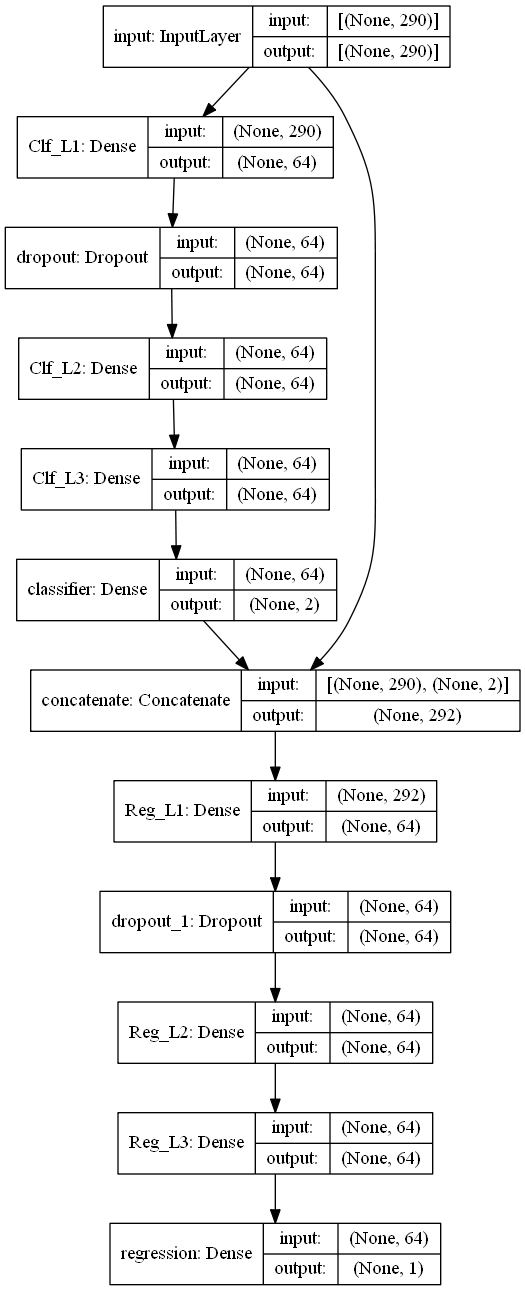

In [50]:
tf.keras.backend.clear_session()
### Create input layer
inputs = tf.keras.Input(shape=(input_size,),name='input') # shape (features,)

### Building the classifier
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L1')(inputs) # shape (None, 64)
clf = tf.keras.layers.Dropout(.2)(clf)
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L2')(clf) # shape (None, 64)
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L3')(clf) # shape (None, 64)
clf_out = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(clf) # shape (None, 2)

### Now build regression portion of model
reg = tf.keras.layers.concatenate([inputs, clf_out],axis=1) # shape (features + 1, )

reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L1')(reg) # shape (None, 64)
reg = tf.keras.layers.Dropout(.2)(reg)
reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L2')(reg) # shape (None, 64)
reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L3')(reg) # shape (None, 64)
reg_out = tf.keras.layers.Dense(1, name='regression')(reg) # shape (None,1)


complex_model = tf.keras.Model(inputs=inputs, outputs = [reg_out, clf_out])

tf.keras.utils.plot_model(complex_model, show_shapes=True)

#complex_model.summary()


In [51]:
complex_model.compile(optimizer='adam',
                     loss={'classifier':tf.keras.losses.BinaryCrossentropy(from_logits=False),
                          'regression': tf.keras.losses.MeanSquaredError()},
                     metrics={'classifier':[tf.keras.metrics.AUC(), 
                                            tf.keras.metrics.Precision(),
                                            tf.keras.metrics.Recall()],
                             'regression': [tf.keras.metrics.RootMeanSquaredError(),
                                          tf.keras.metrics.MeanAbsoluteError()]}
                     )

In [52]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = complex_model.fit(train['inputs'],
                           {'regression':train['targets'],'classifier':train_purchase},
                           epochs=epochs,
                           batch_size=batch_size,
                           callbacks=earlystop,
                           validation_data=(valid['inputs'],{'regression':valid['targets'],
                                                              'classifier':valid_purchase}),
                           verbose=2
                           )

Epoch 1/100
5059/5059 - 13s - loss: 3.1967 - regression_loss: 3.1507 - classifier_loss: 0.0459 - regression_root_mean_squared_error: 1.7750 - regression_mean_absolute_error: 0.3938 - classifier_auc: 0.9963 - classifier_precision: 0.9835 - classifier_recall: 0.9835 - val_loss: 2.8216 - val_regression_loss: 2.7856 - val_classifier_loss: 0.0359 - val_regression_root_mean_squared_error: 1.6690 - val_regression_mean_absolute_error: 0.3265 - val_classifier_auc: 0.9979 - val_classifier_precision: 0.9868 - val_classifier_recall: 0.9868
Epoch 2/100
5059/5059 - 14s - loss: 2.9446 - regression_loss: 2.9064 - classifier_loss: 0.0382 - regression_root_mean_squared_error: 1.7048 - regression_mean_absolute_error: 0.3431 - classifier_auc: 0.9968 - classifier_precision: 0.9864 - classifier_recall: 0.9864 - val_loss: 2.8314 - val_regression_loss: 2.7951 - val_classifier_loss: 0.0363 - val_regression_root_mean_squared_error: 1.6718 - val_regression_mean_absolute_error: 0.3362 - val_classifier_auc: 0.9983

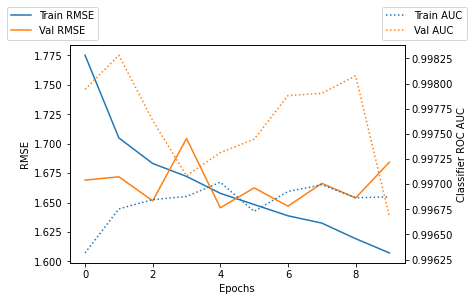

In [53]:
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(history.history['regression_root_mean_squared_error'] ,label='Train RMSE')
ax.plot(history.history['val_regression_root_mean_squared_error'] ,label='Val RMSE')

ax2 = ax.twinx()

ax2.plot(history.history['classifier_auc'],label='Train AUC', linestyle=':')
ax2.plot(history.history['val_classifier_auc'],label = 'Val AUC', linestyle=':')

ax.set_xlabel('Epochs')

ax.set_ylabel('RMSE')
ax2.set_ylabel('Classifier ROC AUC')
ax2.legend(bbox_to_anchor= (1.2, 1.2))
ax.legend(bbox_to_anchor= (0.1, 1.2))
#ax2.legend(loc='upper', bbox_to_anchor= (1.1, 0.6), ncol=1,
 #           borderaxespad=0, frameon=False)
#plt.legend(loc='upper right')
plt.show()

In [54]:
perf = {k:[] for k in ['RMSE', 'ROC AUC', 'Recall']}
for inputs, r_targets,c_targets in zip([train['inputs'],valid['inputs'], test['inputs']],
                                             [train['targets'],valid['targets'], test['targets']],
                                             [train_purchase, valid_purchase, test_purchase]):
    
    dum = complex_model.evaluate(inputs,{'regression':r_targets,'classifier':c_targets})
    perf['RMSE'].append(dum[metrics.index('regression_root_mean_squared_error')])
    perf['ROC AUC'].append(dum[metrics.index('classifier_auc')])
    perf['Recall'].append(dum[metrics.index('classifier_recall')])
    del dum
pd.DataFrame(perf,index = ['train','validation','test'])
    

2257/2257 [==============================] - 3s 1ms/step - loss: 2.8177 - regression_loss: 2.7821 - classifier_loss: 0.0356 - regression_root_mean_squared_error: 1.6680 - regression_mean_absolute_error: 0.3204 - classifier_auc: 0.9968 - classifier_precision: 0.9865 - classifier_recall: 0.9865


,RMSE,ROC AUC,Recall
train,1.610791,0.997348,0.987637
validation,1.645563,0.997313,0.986826
test,1.667958,0.996771,0.986536


In [55]:
### base case 3 layer NN
base_seq_nn

,RMSE
train,1.622523
validation,1.640564
test,1.663484


In [56]:
### Sequential NN with classifier added to features
seq_nn_w_clf

,RMSE
train,1.627873
validation,1.636500
test,1.657454


In [57]:
### Complex NN model 1
complex_nn_exp

,RMSE,ROC AUC,Recall
train,1.584526,0.998415,0.982495
validation,1.656021,0.998241,0.981342
test,1.678265,0.998041,0.980594


## Segmentation modelling

The idea of segmentation modelling is to create multiple models for handling different scenarios, so for example one model for visits on weekdays and another for visits on weekends.  
Current ideas I would like to try for segmentation modelling:
- weekend vs weekday
- visits == 1 and visits >1
- US and international
- Mobile and non-Mobile


The last two require putting columns back into the data that were previously dropped during multicollinearity check. Maybe they will not be helpful, but I'll try.


In [8]:
import tensorflow as tf

In [9]:
wkend = final_features.index('weekendMean')
weekend_ndxs = np.where(train['inputs'][:,wkend]>0.5)
val_weekend_ndxs = np.where(valid['inputs'][:,wkend]>0.5)
weekday_ndxs = np.where(train['inputs'][:,wkend]<=0.5)
val_weekday_ndxs = np.where(valid['inputs'][:,wkend]<=0.5)



X_train_wkend = train['inputs'][weekend_ndxs,:][0]
y_train_wkend = train['targets'][weekend_ndxs]

X_train_wkday = train['inputs'][weekday_ndxs,:][0]
y_train_wkday = train['targets'][weekday_ndxs]


X_valid_wkend = valid['inputs'][val_weekend_ndxs,:][0]
y_valid_wkend = valid['targets'][val_weekend_ndxs]

X_valid_wkday = valid['inputs'][val_weekday_ndxs,:][0]
y_valid_wkday = valid['targets'][val_weekday_ndxs]                   

In [10]:
### Declare some variables for modelling 

input_size = X_train_wkend.shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50


In [11]:
wkend_model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
wkend_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
wkend_model.add(tf.keras.layers.Dropout(0.2))
wkend_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
wkend_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
wkend_model.add(tf.keras.layers.Dense(1))

wkend_model.compile(optimizer='adam', 
                  loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = wkend_model.fit(x=X_train_wkend,
          y=y_train_wkend,
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid_wkend,y_valid_wkend),
          verbose = 2)

Epoch 1/50
235/235 - 1s - loss: 2.4143 - root_mean_squared_error: 1.5538 - mean_absolute_error: 0.3634 - val_loss: 2.0513 - val_root_mean_squared_error: 1.4322 - val_mean_absolute_error: 0.2893
Epoch 2/50
235/235 - 1s - loss: 2.1331 - root_mean_squared_error: 1.4605 - mean_absolute_error: 0.2975 - val_loss: 1.9220 - val_root_mean_squared_error: 1.3863 - val_mean_absolute_error: 0.2578
Epoch 3/50
235/235 - 1s - loss: 2.0654 - root_mean_squared_error: 1.4372 - mean_absolute_error: 0.2840 - val_loss: 1.9168 - val_root_mean_squared_error: 1.3845 - val_mean_absolute_error: 0.2610
Epoch 4/50
235/235 - 1s - loss: 1.9579 - root_mean_squared_error: 1.3993 - mean_absolute_error: 0.2657 - val_loss: 1.8711 - val_root_mean_squared_error: 1.3679 - val_mean_absolute_error: 0.2363
Epoch 5/50
235/235 - 1s - loss: 1.9281 - root_mean_squared_error: 1.3886 - mean_absolute_error: 0.2589 - val_loss: 1.8936 - val_root_mean_squared_error: 1.3761 - val_mean_absolute_error: 0.2341
Epoch 6/50
235/235 - 1s - loss

In [14]:
import matplotlib.pyplot as plt
def PlotLoss(hist):
    plt.plot(np.sqrt(hist.history['loss']), label='Loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

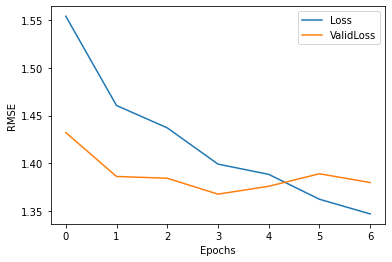

In [17]:
PlotLoss(history)

In [18]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([X_train_wkend,X_valid_wkend],[y_train_wkend,y_valid_wkend]):
    
    dum = wkend_model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
wkend_mod = pd.DataFrame(perf,index = ['train','validation'])
wkend_mod

1043/1043 [==============================] - 1s 715us/step - loss: 1.8711 - root_mean_squared_error: 1.3679 - mean_absolute_error: 0.2363


,RMSE
train,1.347841
validation,1.367869


Wow that is a big improvement when the model was trained only on the weekend visitors.  Unfortunately weekend transactions only account for ~10% of the GStore revenue during this time.  Now I'll do the same for weekday visitors

In [19]:
wkday_model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
wkday_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
wkday_model.add(tf.keras.layers.Dropout(0.2))
wkday_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
wkday_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
wkday_model.add(tf.keras.layers.Dense(1))
                
wkday_model.compile(optimizer='adam', 
                  loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = wkday_model.fit(x=X_train_wkday,
          y=y_train_wkday,
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid_wkday,y_valid_wkday),
          verbose = 2)

Epoch 1/50
778/778 - 2s - loss: 3.6282 - root_mean_squared_error: 1.9048 - mean_absolute_error: 0.4709 - val_loss: 3.1457 - val_root_mean_squared_error: 1.7736 - val_mean_absolute_error: 0.3587
Epoch 2/50
778/778 - 1s - loss: 3.2154 - root_mean_squared_error: 1.7931 - mean_absolute_error: 0.3946 - val_loss: 3.0681 - val_root_mean_squared_error: 1.7516 - val_mean_absolute_error: 0.3541
Epoch 3/50
778/778 - 2s - loss: 3.0974 - root_mean_squared_error: 1.7599 - mean_absolute_error: 0.3795 - val_loss: 2.9811 - val_root_mean_squared_error: 1.7266 - val_mean_absolute_error: 0.3291
Epoch 4/50
778/778 - 2s - loss: 3.0198 - root_mean_squared_error: 1.7377 - mean_absolute_error: 0.3638 - val_loss: 3.0635 - val_root_mean_squared_error: 1.7503 - val_mean_absolute_error: 0.3196
Epoch 5/50
778/778 - 2s - loss: 2.9974 - root_mean_squared_error: 1.7313 - mean_absolute_error: 0.3596 - val_loss: 3.0784 - val_root_mean_squared_error: 1.7545 - val_mean_absolute_error: 0.3201
Epoch 6/50
778/778 - 2s - loss

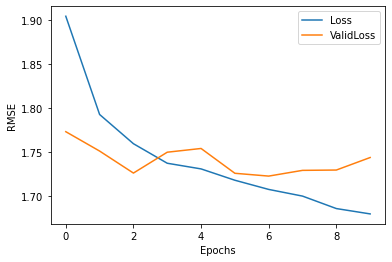

In [21]:
PlotLoss(history)

In [22]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([X_train_wkday,X_valid_wkday],[y_train_wkday,y_valid_wkday]):
    
    dum = wkday_model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
wkday_mod = pd.DataFrame(perf,index = ['train','validation'])
wkday_mod

3477/3477 [==============================] - 2s 684us/step - loss: 2.9692 - root_mean_squared_error: 1.7231 - mean_absolute_error: 0.3123


,RMSE
train,1.666248
validation,1.723142


In [23]:
1.723 * .9 + 1.367 * .1

1.6874000000000002

Because 90% of the GStore revenue during this time comes on weekdays and only 10% on weekends, then this is not an improvement on the base model.  

In [24]:
del X_train_wkend,y_train_wkend,X_train_wkday,y_train_wkday,X_valid_wkend,y_valid_wkend,X_valid_wkday,y_valid_wkday
del wkend,weekend_ndxs,val_weekend_ndxs,weekday_ndxs,val_weekday_ndxs
del wkday_model, wkend_model

Now I will try segmenting on users with one visit and users with multiple visits.

In [25]:
vsts = final_features.index('visits')
vst1_ndxs     = np.where(train['inputs'][:,vsts]<-0.186) ### from standardization
val_vst1_ndxs = np.where(valid['inputs'][:,vsts]<-0.186)
vstM_ndxs     = np.where(train['inputs'][:,vsts]>-0.186)
val_vstM_ndxs = np.where(valid['inputs'][:,vsts]>-0.186)



X_train_vst1 = train['inputs'][vst1_ndxs,:][0]
y_train_vst1 = train['targets'][vst1_ndxs]

X_train_vstM = train['inputs'][vstM_ndxs,:][0]
y_train_vstM = train['targets'][vstM_ndxs]


X_valid_vst1 = valid['inputs'][val_vst1_ndxs,:][0]
y_valid_vst1 = valid['targets'][val_vst1_ndxs]

X_valid_vstM = valid['inputs'][val_vstM_ndxs,:][0]
y_valid_vstM = valid['targets'][val_vstM_ndxs]   

In [27]:
vst1_model = tf.keras.Sequential()
vst1_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
vst1_model.add(tf.keras.layers.Dropout(0.2))
vst1_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
vst1_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
vst1_model.add(tf.keras.layers.Dense(1))          
vst1_model.compile(optimizer='adam', 
                  loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [28]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = vst1_model.fit(x=X_train_vst1,
          y=y_train_vst1,
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid_vst1,y_valid_vst1),
          verbose = 2)

Epoch 1/50
885/885 - 2s - loss: 1.4840 - root_mean_squared_error: 1.2182 - mean_absolute_error: 0.2301 - val_loss: 1.3255 - val_root_mean_squared_error: 1.1513 - val_mean_absolute_error: 0.1543
Epoch 2/50
885/885 - 2s - loss: 1.3704 - root_mean_squared_error: 1.1707 - mean_absolute_error: 0.1904 - val_loss: 1.3016 - val_root_mean_squared_error: 1.1409 - val_mean_absolute_error: 0.1455
Epoch 3/50
885/885 - 3s - loss: 1.3122 - root_mean_squared_error: 1.1455 - mean_absolute_error: 0.1782 - val_loss: 1.5724 - val_root_mean_squared_error: 1.2540 - val_mean_absolute_error: 0.1775
Epoch 4/50
885/885 - 2s - loss: 1.2908 - root_mean_squared_error: 1.1362 - mean_absolute_error: 0.1711 - val_loss: 1.5200 - val_root_mean_squared_error: 1.2329 - val_mean_absolute_error: 0.1628
Epoch 5/50
885/885 - 2s - loss: 1.2668 - root_mean_squared_error: 1.1255 - mean_absolute_error: 0.1678 - val_loss: 1.4742 - val_root_mean_squared_error: 1.2142 - val_mean_absolute_error: 0.1725


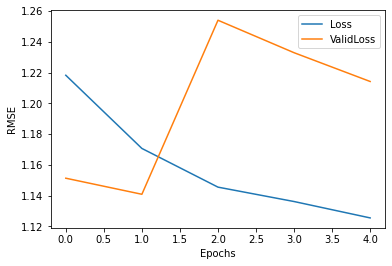

In [29]:
PlotLoss(history)

In [30]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([X_train_vst1,X_valid_vst1],[y_train_vst1,y_valid_vst1]):
    
    dum = vst1_model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
vst1_mod = pd.DataFrame(perf,index = ['train','validation'])
vst1_mod

3953/3953 [==============================] - 3s 685us/step - loss: 1.3016 - root_mean_squared_error: 1.1409 - mean_absolute_error: 0.1455


,RMSE
train,1.139662
validation,1.140867


Much more accurate prediction for users who only visited once, but those users only account for 20% of the revenue.

In [31]:
vstM_model = tf.keras.Sequential()
vstM_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
vstM_model.add(tf.keras.layers.Dropout(0.2))
vstM_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
vstM_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
vstM_model.add(tf.keras.layers.Dense(1))          
vstM_model.compile(optimizer='adam', 
                  loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [32]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = vstM_model.fit(x=X_train_vstM,
          y=y_train_vstM,
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid_vstM,y_valid_vstM),
          verbose = 2)

Epoch 1/50
128/128 - 1s - loss: 17.6445 - root_mean_squared_error: 4.2005 - mean_absolute_error: 2.0166 - val_loss: 14.8906 - val_root_mean_squared_error: 3.8588 - val_mean_absolute_error: 1.6197
Epoch 2/50
128/128 - 0s - loss: 14.4907 - root_mean_squared_error: 3.8067 - mean_absolute_error: 1.6731 - val_loss: 13.5461 - val_root_mean_squared_error: 3.6805 - val_mean_absolute_error: 1.5994
Epoch 3/50
128/128 - 0s - loss: 13.8080 - root_mean_squared_error: 3.7159 - mean_absolute_error: 1.6045 - val_loss: 13.2616 - val_root_mean_squared_error: 3.6417 - val_mean_absolute_error: 1.5136
Epoch 4/50
128/128 - 0s - loss: 13.3591 - root_mean_squared_error: 3.6550 - mean_absolute_error: 1.5458 - val_loss: 13.2216 - val_root_mean_squared_error: 3.6361 - val_mean_absolute_error: 1.5071
Epoch 5/50
128/128 - 0s - loss: 13.1736 - root_mean_squared_error: 3.6295 - mean_absolute_error: 1.5151 - val_loss: 13.1798 - val_root_mean_squared_error: 3.6304 - val_mean_absolute_error: 1.5467
Epoch 6/50
128/128 -

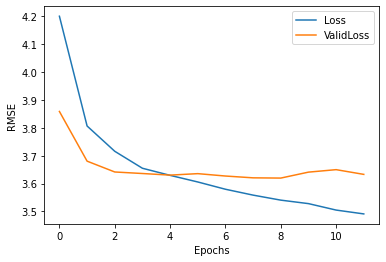

In [33]:
PlotLoss(history)

In [34]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([X_train_vstM,X_valid_vstM],[y_train_vstM,y_valid_vstM]):
    
    dum = vstM_model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
vstM_mod = pd.DataFrame(perf,index = ['train','validation'])
vstM_mod

567/567 [==============================] - 0s 719us/step - loss: 13.1027 - root_mean_squared_error: 3.6198 - mean_absolute_error: 1.4307


,RMSE
train,3.430361
validation,3.619762


In [35]:
del X_train_vstM,X_valid_vstM,y_train_vstM,y_valid_vstM,X_train_vst1,X_valid_vst1,y_train_vst1,y_valid_vst1
del vstM_model, vst1_model,vst1_ndxs,val_vst1_ndxs,vstM_ndxs,val_vstM_ndxs

In [36]:
0.8*3.61 + 1.14 * .2

3.1159999999999997

Bummer.  Becuause ~80% of the revenue in the data comes from users who had multiple visits this pair of models is not an improvement on base model. 



In [37]:
intl = final_features.index('state_NotUSMean')
int_ndxs     = np.where(train['inputs'][:,intl]>0) ### from standardization
val_int_ndxs = np.where(valid['inputs'][:,intl]>0)
usa_ndxs     = np.where(train['inputs'][:,intl]<=0)
val_usa_ndxs = np.where(valid['inputs'][:,intl]<=0)



X_train_int = train['inputs'][int_ndxs,:][0]
y_train_int = train['targets'][int_ndxs]

X_train_usa = train['inputs'][usa_ndxs,:][0]
y_train_usa = train['targets'][usa_ndxs]


X_valid_int = valid['inputs'][val_int_ndxs,:][0]
y_valid_int = valid['targets'][val_int_ndxs]

X_valid_usa = valid['inputs'][val_usa_ndxs,:][0]
y_valid_usa = valid['targets'][val_usa_ndxs]   

In [38]:
import tensorflow as tf

In [39]:
### Declare some variables for modelling 

input_size = X_train_int.shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50


In [40]:
int_model = tf.keras.Sequential()
int_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
int_model.add(tf.keras.layers.Dropout(0.2))
int_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
int_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
int_model.add(tf.keras.layers.Dense(1))          
int_model.compile(optimizer='adam', 
                  loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [41]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = int_model.fit(x=X_train_int,
          y=y_train_int,
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid_int,y_valid_int),
          verbose = 2)

Epoch 1/50
849/849 - 2s - loss: 1.7142 - root_mean_squared_error: 1.3093 - mean_absolute_error: 0.2504 - val_loss: 1.4302 - val_root_mean_squared_error: 1.1959 - val_mean_absolute_error: 0.1996
Epoch 2/50
849/849 - 2s - loss: 1.5495 - root_mean_squared_error: 1.2448 - mean_absolute_error: 0.2082 - val_loss: 1.3951 - val_root_mean_squared_error: 1.1812 - val_mean_absolute_error: 0.1731
Epoch 3/50
849/849 - 2s - loss: 1.5048 - root_mean_squared_error: 1.2267 - mean_absolute_error: 0.1925 - val_loss: 1.4239 - val_root_mean_squared_error: 1.1933 - val_mean_absolute_error: 0.1808
Epoch 4/50
849/849 - 2s - loss: 1.4882 - root_mean_squared_error: 1.2199 - mean_absolute_error: 0.1870 - val_loss: 1.3925 - val_root_mean_squared_error: 1.1801 - val_mean_absolute_error: 0.1740
Epoch 5/50
849/849 - 3s - loss: 1.4489 - root_mean_squared_error: 1.2037 - mean_absolute_error: 0.1824 - val_loss: 1.3901 - val_root_mean_squared_error: 1.1790 - val_mean_absolute_error: 0.1586
Epoch 6/50
849/849 - 2s - loss

In [42]:
import matplotlib.pyplot as plt
def PlotLoss(hist):
    plt.plot(np.sqrt(hist.history['loss']), label='Loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    

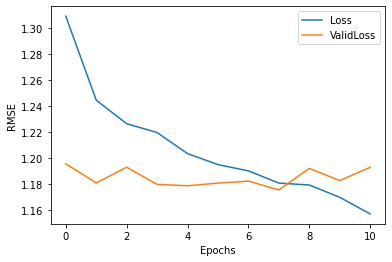

In [43]:
PlotLoss(history)

In [44]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([X_train_int,X_valid_int],[y_train_int,y_valid_int]):
    
    dum = int_model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
int_mod = pd.DataFrame(perf,index = ['train','validation'])
int_mod

3792/3792 [==============================] - 4s 1ms/step - loss: 1.3825 - root_mean_squared_error: 1.1758 - mean_absolute_error: 0.1696


,RMSE
train,1.146795
validation,1.175801


The prediction for international visitors has a much lower RMSE, but...... 94% of the revenue comes from USA visitors. 

In [45]:
### Declare some variables for modelling 

input_size = X_train_usa.shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50


In [46]:
usa_model = tf.keras.Sequential()
usa_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
usa_model.add(tf.keras.layers.Dropout(0.2))
usa_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
usa_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
usa_model.add(tf.keras.layers.Dense(1))          
usa_model.compile(optimizer='adam', 
                  loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [47]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = usa_model.fit(x=X_train_usa,
          y=y_train_usa,
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid_usa,y_valid_usa),
          verbose = 2)

Epoch 1/50
164/164 - 1s - loss: 13.1624 - root_mean_squared_error: 3.6280 - mean_absolute_error: 1.5191 - val_loss: 10.5529 - val_root_mean_squared_error: 3.2485 - val_mean_absolute_error: 1.1978
Epoch 2/50
164/164 - 0s - loss: 10.6299 - root_mean_squared_error: 3.2603 - mean_absolute_error: 1.2667 - val_loss: 10.0317 - val_root_mean_squared_error: 3.1673 - val_mean_absolute_error: 1.1090
Epoch 3/50
164/164 - 0s - loss: 10.1703 - root_mean_squared_error: 3.1891 - mean_absolute_error: 1.2003 - val_loss: 9.7198 - val_root_mean_squared_error: 3.1177 - val_mean_absolute_error: 1.1024
Epoch 4/50
164/164 - 0s - loss: 9.7496 - root_mean_squared_error: 3.1224 - mean_absolute_error: 1.1394 - val_loss: 9.6641 - val_root_mean_squared_error: 3.1087 - val_mean_absolute_error: 1.0580
Epoch 5/50
164/164 - 0s - loss: 9.5730 - root_mean_squared_error: 3.0940 - mean_absolute_error: 1.1264 - val_loss: 9.6261 - val_root_mean_squared_error: 3.1026 - val_mean_absolute_error: 1.0455
Epoch 6/50
164/164 - 0s -

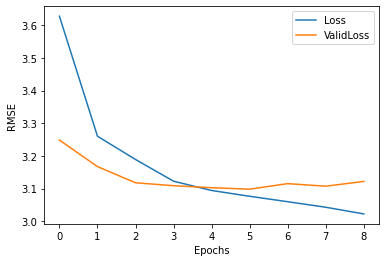

In [48]:
PlotLoss(history)

In [49]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([X_train_usa,X_valid_usa],[y_train_usa,y_valid_usa]):
    
    dum = usa_model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
usa_mod = pd.DataFrame(perf,index = ['train','validation'])
usa_mod

727/727 [==============================] - 1s 716us/step - loss: 9.5982 - root_mean_squared_error: 3.0981 - mean_absolute_error: 1.0618


,RMSE
train,2.988805
validation,3.098097


In [50]:
0.94*3.098 + .06* 1.18

2.98292

The prediction for USA visitors, where 94% of the revenue comes from, is much worse than before.  This pair of segmentation models will not be helpful.  Finally I will try a pair of models for mobile visitors and non-mobile visitors

In [51]:
mobile = final_features.index('isMobileMean')

In [52]:
mobile = final_features.index('isMobileMean')
mob_ndxs     = np.where(train['inputs'][:,mobile]>=0.5) ### from standardization
val_mob_ndxs = np.where(valid['inputs'][:,mobile]>=0.5)
dsk_ndxs     = np.where(train['inputs'][:,mobile]<0.5)
val_dsk_ndxs = np.where(valid['inputs'][:,mobile]<0.5)



X_train_mob =  train['inputs'][mob_ndxs,:][0]
y_train_mob = train['targets'][mob_ndxs]

X_train_dsk =  train['inputs'][dsk_ndxs,:][0]
y_train_dsk = train['targets'][dsk_ndxs]


X_valid_mob =  valid['inputs'][val_mob_ndxs,:][0]
y_valid_mob = valid['targets'][val_mob_ndxs]

X_valid_dsk =  valid['inputs'][val_dsk_ndxs,:][0]
y_valid_dsk = valid['targets'][val_dsk_ndxs]   

In [53]:
### Declare some variables for modelling 

input_size = X_train_mob.shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50


In [54]:
mob_model = tf.keras.Sequential()
mob_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
mob_model.add(tf.keras.layers.Dropout(0.2))
mob_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
mob_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
mob_model.add(tf.keras.layers.Dense(1))          
mob_model.compile(optimizer='adam', 
                  loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [55]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = mob_model.fit(x=X_train_mob,
          y=y_train_mob,
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid_mob,y_valid_mob),
          verbose = 2)

Epoch 1/50
270/270 - 1s - loss: 1.4725 - root_mean_squared_error: 1.2135 - mean_absolute_error: 0.2501 - val_loss: 1.3354 - val_root_mean_squared_error: 1.1556 - val_mean_absolute_error: 0.2001
Epoch 2/50
270/270 - 1s - loss: 1.3732 - root_mean_squared_error: 1.1718 - mean_absolute_error: 0.2189 - val_loss: 1.2841 - val_root_mean_squared_error: 1.1332 - val_mean_absolute_error: 0.2003
Epoch 3/50
270/270 - 1s - loss: 1.3330 - root_mean_squared_error: 1.1546 - mean_absolute_error: 0.1995 - val_loss: 1.2573 - val_root_mean_squared_error: 1.1213 - val_mean_absolute_error: 0.1846
Epoch 4/50
270/270 - 1s - loss: 1.2972 - root_mean_squared_error: 1.1390 - mean_absolute_error: 0.1852 - val_loss: 1.2502 - val_root_mean_squared_error: 1.1181 - val_mean_absolute_error: 0.1605
Epoch 5/50
270/270 - 1s - loss: 1.2652 - root_mean_squared_error: 1.1248 - mean_absolute_error: 0.1757 - val_loss: 1.2679 - val_root_mean_squared_error: 1.1260 - val_mean_absolute_error: 0.1538
Epoch 6/50
270/270 - 1s - loss

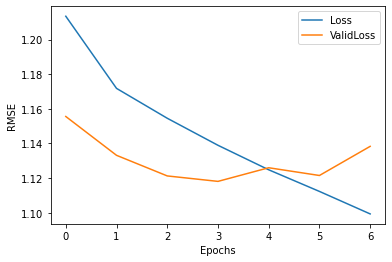

In [56]:
PlotLoss(history)

In [57]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([X_train_mob,X_valid_mob],[y_train_mob,y_valid_mob]):
    
    dum = mob_model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
mob_mod = pd.DataFrame(perf,index = ['train','validation'])
mob_mod

1210/1210 [==============================] - 1s 853us/step - loss: 1.2502 - root_mean_squared_error: 1.1181 - mean_absolute_error: 0.1605


,RMSE
train,1.108610
validation,1.118128


The prediction for mobile visitors is quite good, with a low RMSE score.  Now creating a model for "desktop" visitors

In [58]:
### Declare some variables for modelling 

input_size = X_train_dsk.shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50


In [59]:
dsk_model = tf.keras.Sequential()
dsk_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
dsk_model.add(tf.keras.layers.Dropout(0.2))
dsk_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
dsk_model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
dsk_model.add(tf.keras.layers.Dense(1))          
dsk_model.compile(optimizer='adam', 
                  loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [60]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = dsk_model.fit(x=X_train_dsk,
          y=y_train_dsk,
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid_dsk,y_valid_dsk),
          verbose = 2)

Epoch 1/50
743/743 - 4s - loss: 3.9467 - root_mean_squared_error: 1.9866 - mean_absolute_error: 0.5125 - val_loss: 3.3546 - val_root_mean_squared_error: 1.8316 - val_mean_absolute_error: 0.4022
Epoch 2/50
743/743 - 2s - loss: 3.4931 - root_mean_squared_error: 1.8690 - mean_absolute_error: 0.4301 - val_loss: 3.4342 - val_root_mean_squared_error: 1.8532 - val_mean_absolute_error: 0.4051
Epoch 3/50
743/743 - 2s - loss: 3.4202 - root_mean_squared_error: 1.8494 - mean_absolute_error: 0.4181 - val_loss: 3.2674 - val_root_mean_squared_error: 1.8076 - val_mean_absolute_error: 0.3947
Epoch 4/50
743/743 - 2s - loss: 3.3249 - root_mean_squared_error: 1.8234 - mean_absolute_error: 0.3954 - val_loss: 3.3824 - val_root_mean_squared_error: 1.8391 - val_mean_absolute_error: 0.3639
Epoch 5/50
743/743 - 2s - loss: 3.2851 - root_mean_squared_error: 1.8125 - mean_absolute_error: 0.3990 - val_loss: 3.3305 - val_root_mean_squared_error: 1.8250 - val_mean_absolute_error: 0.3898
Epoch 6/50
743/743 - 2s - loss

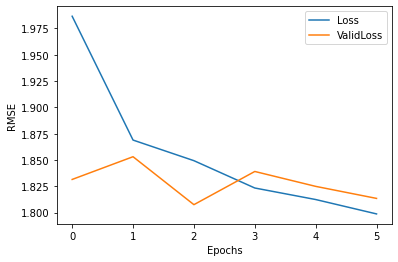

In [61]:
PlotLoss(history)

In [62]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([X_train_dsk,X_valid_dsk],[y_train_dsk,y_valid_dsk]):
    
    dum = dsk_model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
dsk_mod = pd.DataFrame(perf,index = ['train','validation'])
dsk_mod

3310/3310 [==============================] - 2s 695us/step - loss: 3.2674 - root_mean_squared_error: 1.8076 - mean_absolute_error: 0.3947


,RMSE
train,1.789909
validation,1.807590


In [63]:
###
1.8*.96 + 1.11*.04

1.7724

The RMSE for "desktop" visitors is a much higher than the original models RMSE of ~1.65.  "Desktop" users also account for 96% of the GStore revenue during this time so this pair of models is not an improvement on the base model.  

At this time I will go back and check the distribution of revenue among mobile and "desktop" visitors, but I believe that majority of the revenue comes from "desktop" visitors.

## Decision time 
This model produced a test RMSE that is a tiny bit higher than the two sequential models, and it appears to be overfit to the same degree as the other models.  I will proceed with the standard sequential NN. 

In [6]:
import tensorflow as tf

In [31]:
tf.keras.backend.clear_session()

In [32]:
### Declare some variables for modelling 

input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 32
batch_size = 500
epochs = 50


Model building

In [33]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [34]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = model.fit(x=train['inputs'],
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(valid['inputs'],valid['targets']),
          verbose = 2)

Epoch 1/50
1012/1012 - 3s - loss: 3.3961 - root_mean_squared_error: 1.8428 - mean_absolute_error: 0.4437 - val_loss: 2.8121 - val_root_mean_squared_error: 1.6769 - val_mean_absolute_error: 0.4099
Epoch 2/50
1012/1012 - 2s - loss: 2.9601 - root_mean_squared_error: 1.7205 - mean_absolute_error: 0.3661 - val_loss: 2.8009 - val_root_mean_squared_error: 1.6736 - val_mean_absolute_error: 0.3086
Epoch 3/50
1012/1012 - 2s - loss: 2.8968 - root_mean_squared_error: 1.7020 - mean_absolute_error: 0.3555 - val_loss: 2.7422 - val_root_mean_squared_error: 1.6560 - val_mean_absolute_error: 0.3072
Epoch 4/50
1012/1012 - 2s - loss: 2.8272 - root_mean_squared_error: 1.6814 - mean_absolute_error: 0.3432 - val_loss: 2.7137 - val_root_mean_squared_error: 1.6473 - val_mean_absolute_error: 0.3223
Epoch 5/50
1012/1012 - 2s - loss: 2.7836 - root_mean_squared_error: 1.6684 - mean_absolute_error: 0.3376 - val_loss: 2.6870 - val_root_mean_squared_error: 1.6392 - val_mean_absolute_error: 0.3171
Epoch 6/50
1012/1012

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.style.use('seaborn')
sns.set_context("talk")

def PlotLoss(hist):
    
    plt.plot(np.sqrt(hist.history['loss']), label='Training')
    plt.plot(np.sqrt(history.history['val_loss']), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('Model performance during training')
    #plt.legend(labels=['Training','Validation'])
    plt.show()
    

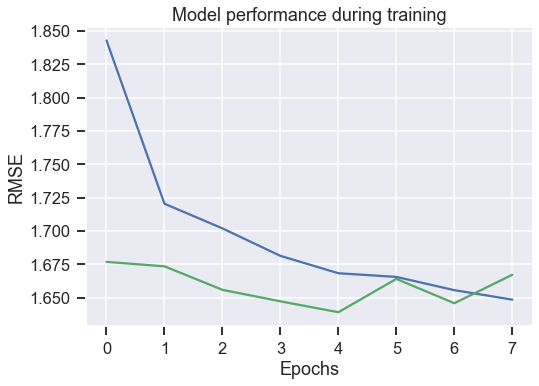

In [36]:
PlotLoss(history)

In [37]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([train['inputs'],valid['inputs'], test['inputs']],
                                             [train['targets'],valid['targets'], test['targets']]):
    
    dum = model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
base_seq_nn = pd.DataFrame(perf,index = ['train','validation','test'])
base_seq_nn

2257/2257 [==============================] - 1s 617us/step - loss: 2.7498 - root_mean_squared_error: 1.6582 - mean_absolute_error: 0.3198


,RMSE
train,1.628863
validation,1.639211
test,1.658243


In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                9312      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 11,457
Trainable params: 11,457
Non-trainable params: 0
_________________________________________________________________


### Final Model
Above is the final model and the RMSE scores for the train, validation and test sets.  Reducing the features through VIF reduced the overfitting of the model but did come at the cost of increasing RMSE for validation and test sets.  


In [39]:
model.save(r'C:\Users\blain\GitHub\Capstone_GA-Revenue-Prediction\final_nn_model_user_revenue')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When f

Now to help the marketing team I will use the `shap` library to explain the model and it's features. 

In [16]:
#final_features

In [14]:
import shap
shap.initjs()

To reduce computation time I will extract a small number of samples from the training set (for background) and the test set (for shap_value calculation).  I will do a 'somewhat balnaced' sampling to ensure that there are non-zero revenue users in each set. 

In [19]:
train['inputs'].shape

(505867, 290)

In [21]:
### Create subset of background for shap calculation 

nonpurchasers = 40
purchasers = 10

nonp = np.array(np.where(train['targets']==0.0)).reshape(-1,)
nonp_samps = np.random.choice(nonp,size = nonpurchasers)

purch = np.array(np.where(train['targets']>0)).reshape(-1,)
purch_samps = np.random.choice(purch, size = purchasers)

background_rand_samples = np.concatenate([nonp_samps,purch_samps])
del  nonp, nonp_samps, purch, purch_samps

background = train['inputs'][background_rand_samples,:]

background = pd.DataFrame(background,columns=final_features)

background.shape


(50, 290)

In [22]:
### Create subset for shap pertrubations 
nonpurchasers = 400
purchasers = 100

nonp = np.array(np.where(valid['targets']==0.0)).reshape(-1,)
nonp_samps = np.random.choice(nonp,size = nonpurchasers)

purch = np.array(np.where(valid['targets']>0)).reshape(-1,)
purch_samps = np.random.choice(purch, size = purchasers)

shap_random_samples = np.concatenate([nonp_samps,purch_samps])
del  nonp, nonp_samps, purch, purch_samps

shapdata = valid['inputs'][shap_random_samples,:]


shapdata = pd.DataFrame(shapdata,columns=final_features)

shapdata.shape

(500, 290)

In [23]:
explainer = shap.explainers.Permutation(model.predict, background)

In [24]:
shap_values = explainer(shapdata)

Permutation explainer: 501it [21:24,  2.59s/it]                         


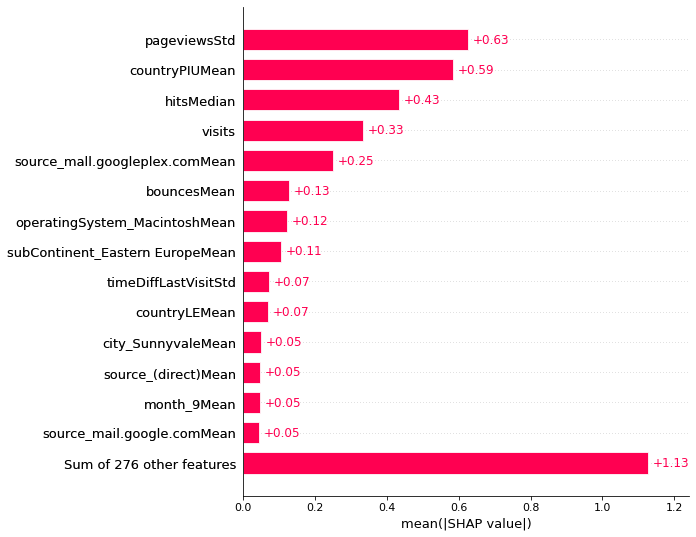

In [27]:
shap.plots.bar(shap_values,max_display=15)


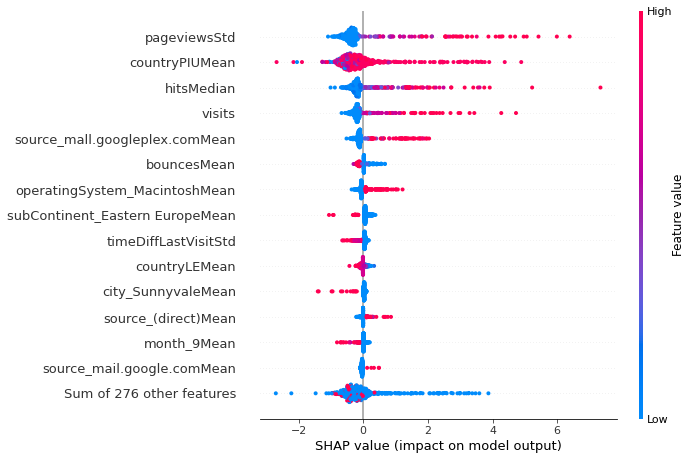

In [28]:
shap.plots.beeswarm(shap_values, max_display=15)